In [1]:

import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
# TRAVILY_PROJECT = os.getenv("TRAVILY_PROJECT")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING")
os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT")
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT")

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")



In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest")

In [6]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

In [7]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--63423469-cf4c-4801-989f-6a8a3e1531f1-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [22]:
tavily_tool=TavilySearchResults()

In [23]:
code = """
x = 5
y = x * 2tavaily_tool.invoke("what is a gdp?")
print(y)
"""

In [24]:

repl=PythonREPL()

In [25]:

repl=PythonREPL()

In [26]:

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [56]:

members=["grab-food","grab-car","grab-express"]

In [57]:
options=members+["FINISH"]

In [58]:
options


['grab-food', 'grab-car', 'grab-express', 'FINISH']

In [59]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal['researcher', 'coder', 'FINISH']

In [60]:
class State(MessagesState):
    next:str

In [61]:
system_prompt=f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [62]:
[{"role": "system", "content": system_prompt},]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['grab-food', 'grab-car', 'grab-express']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"}]

In [74]:
def supervisor_node(state: State) -> Command[Literal["grab-car", "grab-express","grab-food", "__end__"]]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    response = llm.with_structured_output(Router).invoke(messages)
    
    goto = response["next"]
    
    print("below my goto**********************************")
    
    print(goto)
    
    if goto == "FINISH":
        goto = END
        
    return Command(goto=goto, update={"next": goto})

In [75]:
def research_node(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(llm, tools=[tavaily_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result = research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [76]:
def code_node(state: State) -> Command[Literal["supervisor"]]:
    
    code_agent = create_react_agent(llm, tools=[python_repl_tool])
    
    result = code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [97]:
def ghj(state: State) -> Command[Literal["supervisor"]]:
    agent=create_react_agent(llm,tools=[tavily_tool])
    result=agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="grab-express")
            ]
        },
        goto="supervisor",
    )

In [ ]:
tools=[tavily_tool]

In [106]:
def router(state) -> Literal["tools", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "tools"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue

SyntaxError: unterminated string literal (detected at line 11) (88402104.py, line 11)

In [98]:

graph=StateGraph(State)

In [99]:

graph.add_node("supervisor",supervisor_node)

In [100]:
graph.add_node("grab-food", research_node)

In [101]:
graph.add_node("grab-express",ghj)

In [102]:

graph.add_node("grab-car", code_node)

In [103]:
graph.add_edge(START,"supervisor")

In [104]:

app=graph.compile()

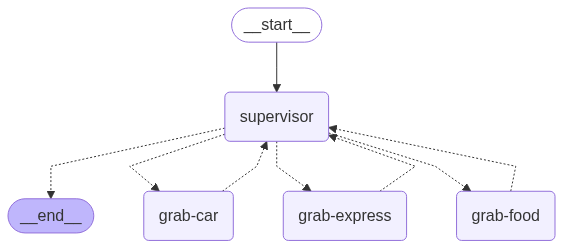

In [105]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [45]:
# With the graph created, we can now invoke it and see how it performs!
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("----")

below my goto**********************************
researcher
((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:9661a303-09a0-99e6-23af-4a6901241ad2',), {'agent': {'messages': [AIMessage(content="I cannot calculate the square root of 42. I'm a researcher, I don't do math calculations, but I can research information to help answer your questions. Is there anything else I can help you with?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--80e462d8-c309-4e64-b195-ee2d2fa3a814-0', usage_metadata={'input_tokens': 71, 'output_tokens': 47, 'total_tokens': 118, 'input_token_details': {'cache_read': 0}})]}})
----
((), {'researcher': {'messages': [HumanMessage(content="I cannot calculate the square root of 42. I'm a researcher, I don't do math calculations, but I can research information to help answer your questions. Is there anything el

Python REPL can execute arbitrary code. Use with caution.


(('coder:655a66db-f9db-20df-3cb4-2d3d4bcf1280',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'python_repl_tool', 'arguments': '{"code": "import math\\nprint(math.sqrt(42))"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--c81b6d21-3fdd-498d-857b-2e4339efcb4c-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nprint(math.sqrt(42))'}, 'id': 'c725c7f8-62b8-423a-9ffd-7aae4ef834b1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 116, 'output_tokens': 18, 'total_tokens': 134, 'input_token_details': {'cache_read': 0}})]}})
----
(('coder:655a66db-f9db-20df-3cb4-2d3d4bcf1280',), {'tools': {'messages': [ToolMessage(content='Successfully executed:\n\\`\\`\\`python\nimport math\nprint(math.sqrt(42))\n\\`\\`\\`\nStdout: 6.48074069840786\n', name='python_repl_tool', id='4cdc4028-cd29-4891-bbde